In [ ]:
!pip install transformers==3.0

     |████████████████████████████████| 757kB 5.4MB/s 
     |████████████████████████████████| 3.0MB 32.4MB/s 
     |████████████████████████████████| 870kB 46.6MB/s 
     |████████████████████████████████| 1.2MB 35.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=f3d0768b5b80f2c17d0e5232b3e565a31c813f6138bf491f95d831eddc942f32
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import transformers

from transformers import AutoModel, BertTokenizerFast

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from wordcloud import WordCloud, STOPWORDS

In [ ]:
with open("StopWords.txt") as f:
    stop_words = f.read()

stop_words = stop_words.split("\n")
stop_words_dict = {}
for stop_word in stop_words:
    stop_words_dict[stop_word] = 1

In [ ]:
utterances_data = pd.read_csv("utterance_data.csv")

In [ ]:
utterances_data

,utterance
0,i need $20000 transferred from my savings to m...
1,complete a transaction from savings to checkin...
2,transfer $20000 from my savings account to che...
3,take $20000 from savings and put it in checking
4,put $20000 into my checking account from my sa...
...,...
2245,give weather update now
2246,want to know the weather
2247,tell me the weather for today
2248,what is the current weather like


#1. BERT

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

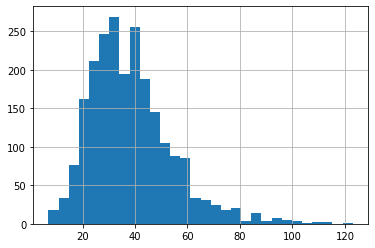

In [ ]:
seq_len = [len(row["utterance"]) for index, row in utterances_data.iterrows()]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
bert_encoding_list = []
T=70
 
for index, row in utterances_data.iterrows():
  sentence = row["utterance"]
  tokens=tokenizer.tokenize(sentence)
  tokens = ['[CLS]'] + tokens + ['[SEP]']
  padded_tokens=tokens +['[PAD]' for _ in range(T-len(tokens))]
  attn_mask=[ 1 if token != '[PAD]' else 0 for token in padded_tokens  ]
  seg_ids=[0 for _ in range(len(padded_tokens))]
  sent_ids=tokenizer.convert_tokens_to_ids(padded_tokens)
  token_ids = torch.tensor(sent_ids).unsqueeze(0) 
  attn_mask = torch.tensor(attn_mask).unsqueeze(0) 
  seg_ids   = torch.tensor(seg_ids).unsqueeze(0)
  hidden_reps, cls_head = bert(token_ids, attention_mask = attn_mask,token_type_ids = seg_ids)
  bert_encoding_list.append(cls_head.detach().cpu().numpy())

bert_vector_df = pd.DataFrame(np.array(bert_encoding_list).reshape(2250, 768))


In [52]:
bert_vector_df = pd.DataFrame(np.array(bert_encoding_list).reshape(2250, 768))
bert_vector_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.779483,-0.277591,0.158460,0.558913,-0.092274,-0.075666,0.675741,0.119754,0.142286,-0.999762,0.144772,0.541105,0.988408,-0.028891,0.914159,-0.395088,-0.003456,-0.498484,0.190220,-0.128883,0.522418,0.980327,0.632664,0.167761,0.308353,0.730338,-0.479371,0.926792,0.949626,0.651495,-0.491576,0.066862,-0.991237,-0.005459,0.082467,-0.985191,0.163448,-0.743078,0.100422,0.248054,...,-0.521180,-0.240690,-0.209734,-0.669847,0.729709,-0.386564,-0.337495,-0.346278,0.507426,0.214173,0.982061,0.236862,0.090015,-0.173242,-0.203911,0.241433,-0.164159,-0.999990,0.215838,0.168123,-0.075916,0.109470,-0.057204,0.046743,-0.914574,-0.056095,0.360907,-0.095634,-0.474275,-0.309067,0.425129,0.483206,0.271316,0.838743,0.554919,0.696747,0.515888,0.316323,-0.591495,0.923210
1,-0.870756,-0.371264,-0.881224,0.720951,0.639245,-0.199966,0.718038,0.189464,-0.784901,-0.999966,-0.782704,0.934289,0.985142,0.602715,0.819388,-0.685908,-0.380071,-0.590246,0.389665,0.149344,0.585222,0.999971,-0.156277,0.256134,0.621774,0.985741,-0.724189,0.868586,0.925583,0.766021,-0.457108,0.316206,-0.991712,-0.239112,-0.908643,-0.994549,0.397128,-0.750678,-0.027774,0.221378,...,0.141755,-0.494479,-0.359814,-0.701521,0.636254,-0.632276,-0.625501,-0.662725,0.791727,0.313002,0.999985,-0.811267,-0.886199,-0.587958,-0.546735,0.418788,-0.677742,-1.000000,0.251164,-0.392268,0.742279,-0.845600,0.710497,-0.740468,-0.923907,-0.419862,0.725835,0.769044,-0.492706,-0.749647,0.566934,-0.523489,0.967490,0.754480,-0.459779,0.234935,0.675692,-0.768633,-0.666561,0.757441
2,-0.763623,-0.327897,-0.460765,0.579945,0.257657,-0.096249,0.589822,0.126807,-0.264713,-0.999837,-0.258866,0.829397,0.983902,0.154870,0.813983,-0.382073,-0.093750,-0.505415,0.282888,0.139943,0.536989,0.997837,0.418475,0.126436,0.452456,0.932098,-0.574125,0.860627,0.919397,0.611314,-0.356170,0.216648,-0.989741,-0.056519,-0.450037,-0.988927,0.286927,-0.692226,0.159694,0.240220,...,-0.289558,-0.359910,-0.227938,-0.631608,0.626764,-0.522565,-0.487723,-0.412975,0.630368,0.312896,0.998891,-0.339914,-0.553784,-0.384646,-0.373382,0.280115,-0.391560,-1.000000,0.147985,-0.071648,0.328496,-0.397033,0.261945,-0.377366,-0.922499,-0.217626,0.523666,0.256474,-0.456254,-0.576775,0.359989,-0.104684,0.784621,0.808247,0.120008,0.552851,0.449351,-0.119506,-0.593662,0.828387
3,-0.845083,-0.364618,-0.815836,0.801210,0.634482,-0.020170,0.840439,0.146608,-0.694122,-0.999952,-0.705135,0.922382,0.984690,0.297921,0.902794,-0.605858,-0.368519,-0.590034,0.251999,-0.034622,0.550094,0.999926,0.181653,0.177568,0.373716,0.987779,-0.738872,0.930166,0.923613,0.638905,-0.518220,0.177857,-0.989578,-0.099340,-0.832744,-0.991824,0.346436,-0.717681,0.112455,0.307401,...,-0.109913,-0.388026,-0.239457,-0.671783,0.721006,-0.603097,-0.603841,-0.605774,0.764832,0.268658,0.999971,-0.678380,-0.808154,-0.469937,-0.430082,0.342545,-0.658722,-1.000000,0.191205,-0.263145,0.614229,-0.784408,0.663341,-0.630713,-0.965407,-0.297068,0.646556,0.722420,-0.505614,-0.706557,0.510911,-0.208919,0.972356,0.835540,-0.057836,0.363377,0.636519,-0.558599,-0.611128,0.892909
4,-0.791664,-0.303655,-0.367204,0.605522,0.281903,-0.061270,0.663327,0.090802,-0.203056,-0.999845,-0.226963,0.863529,0.986437,-0.003987,0.874265,-0.498535,-0.110964,-0.510122,0.200593,-0.052826,0.573274,0.993555,0.386085,0.092538,0.401484,0.928624,-0.603452,0.887688,0.923322,0.659643,-0.436196,0.129060,-0.991692,0.091941,-0.253961,-0.991575,0.220652,-0.678862,0.244729,0.316319,...,-0.398542,-0.280778,-0.218194,-0.583805,0.679440,-0.658832,-0.423833,-0.386302,0.582363,0.258003,0.997228,-0.229242,-0.520644,-0.346958,-0.345492,0.283562,-0.340232,-0.999999,0.134233,0.078911,0.173158,-0.481535,0.166216,-0.336750,-0.933249,-0.162893,0.541676,0.156404,-0.418562

### a. No Pre-processing

### 5 clusters

In [56]:
num_clusters = 5
k_means_obj = KMeans(n_clusters=num_clusters)
k_means_obj.fit(bert_vector_df)
labels = k_means_obj.labels_

## Calculating silhoutte score
## The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

sil_score = silhouette_score(bert_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 5 clusters, got a Silhoutte Score of 0.3416789770126343


In [ ]:
# fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(20,20))

# ax_list = [ax1, ax2, ax3]
# wordcloud_list = [create_word_cloud(i, cluster_indices_dict) for i in range(num_clusters)]

# ax1[0].set_title("Cluster 1")
# ax1[1].set_title("Cluster 2")
# ax2[0].set_title("Cluster 3")
# ax2[1].set_title("Cluster 4")
# ax3[0].set_title("Cluster 5")

# ax1[0].imshow(wordcloud_list[0])
# ax1[1].imshow(wordcloud_list[1])
# ax2[0].imshow(wordcloud_list[2])
# ax2[1].imshow(wordcloud_list[3])
# ax3[0].imshow(wordcloud_list[4])

### 10 clusters

In [63]:
num_clusters = 10
k_means_obj = KMeans(n_clusters=num_clusters)
k_means_obj.fit(bert_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(bert_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 10 clusters, got a Silhoutte Score of 0.24327099323272705


In [ ]:
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize=(10 ,30))
# wordcloud_list = [create_word_cloud(i, cluster_indices_dict) for i in range(num_clusters)]

# ax1[0].set_title("Cluster 1")
# ax1[1].set_title("Cluster 2")
# ax2[0].set_title("Cluster 3")
# ax2[1].set_title("Cluster 4")
# ax3[0].set_title("Cluster 5")
# ax3[1].set_title("Cluster 6")
# ax4[0].set_title("Cluster 7")
# ax4[1].set_title("Cluster 8")
# ax5[0].set_title("Cluster 9")
# ax5[1].set_title("Cluster 10")

# ax1[0].imshow(wordcloud_list[0])
# ax1[1].imshow(wordcloud_list[1])
# ax2[0].imshow(wordcloud_list[2])
# ax2[1].imshow(wordcloud_list[3])
# ax3[0].imshow(wordcloud_list[4])
# ax3[1].imshow(wordcloud_list[5])
# ax4[0].imshow(wordcloud_list[6])
# ax4[1].imshow(wordcloud_list[7])
# ax5[0].imshow(wordcloud_list[8])
# ax5[1].imshow(wordcloud_list[9])

### 15 clusters

In [70]:
num_clusters = 15
k_means_obj = KMeans(n_clusters=num_clusters)
k_means_obj.fit(bert_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(bert_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 15 clusters, got a Silhoutte Score of 0.2021736353635788


In [ ]:
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 3, figsize=(20 ,30))
# wordcloud_list = [create_word_cloud(i, cluster_indices_dict) for i in range(num_clusters)]

# ax1[0].set_title("Cluster 1")
# ax1[1].set_title("Cluster 2")
# ax1[2].set_title("Cluster 3")
# ax2[0].set_title("Cluster 4")
# ax2[1].set_title("Cluster 5")
# ax2[2].set_title("Cluster 6")
# ax3[0].set_title("Cluster 7")
# ax3[1].set_title("Cluster 8")
# ax3[2].set_title("Cluster 9")
# ax4[0].set_title("Cluster 10")
# ax4[1].set_title("Cluster 11")
# ax4[2].set_title("Cluster 12")
# ax5[0].set_title("Cluster 13")
# ax3[1].set_title("Cluster 14")
# ax5[2].set_title("Cluster 15")

# ax1[0].imshow(wordcloud_list[0])
# ax1[1].imshow(wordcloud_list[1])
# ax1[2].imshow(wordcloud_list[2])
# ax2[0].imshow(wordcloud_list[3])
# ax2[1].imshow(wordcloud_list[4])
# ax2[2].imshow(wordcloud_list[5])
# ax3[0].imshow(wordcloud_list[6])
# ax3[1].imshow(wordcloud_list[7])
# ax3[2].imshow(wordcloud_list[8])
# ax4[0].imshow(wordcloud_list[9])
# ax4[1].imshow(wordcloud_list[10])
# ax4[2].imshow(wordcloud_list[11])
# ax5[0].imshow(wordcloud_list[12])
# ax5[1].imshow(wordcloud_list[13])
# ax5[2].imshow(wordcloud_list[14])

### b. Remove Stop Words

In [71]:
def _remove_stop_words_from_sentence(sentence):
    tokens = sentence.split()
    new_tokens = []
    
    for token in tokens:
        if token in stop_words_dict:
            continue
        else:
            new_tokens.append(token)
            
    return " ".join(new_tokens)

In [73]:
bert_encoding_list = []
T=70
 
for index, row in utterances_data.iterrows():
  print(index)
  sentence = _remove_stop_words_from_sentence(row["utterance"])
  tokens=tokenizer.tokenize(sentence)
  tokens = ['[CLS]'] + tokens + ['[SEP]']
  padded_tokens=tokens +['[PAD]' for _ in range(T-len(tokens))]
  attn_mask=[ 1 if token != '[PAD]' else 0 for token in padded_tokens  ]
  seg_ids=[0 for _ in range(len(padded_tokens))]
  sent_ids=tokenizer.convert_tokens_to_ids(padded_tokens)
  token_ids = torch.tensor(sent_ids).unsqueeze(0) 
  attn_mask = torch.tensor(attn_mask).unsqueeze(0) 
  seg_ids   = torch.tensor(seg_ids).unsqueeze(0)
  hidden_reps, cls_head = bert(token_ids, attention_mask = attn_mask,token_type_ids = seg_ids)
  bert_encoding_list.append(cls_head.detach().cpu().numpy())

bert_vector_df = pd.DataFrame(np.array(bert_encoding_list).reshape(2250, 768))
bert_vector_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.766641,-0.406134,-0.766562,0.689286,0.435146,-0.162131,0.826330,0.216882,-0.507121,-0.999965,-0.519838,0.859707,0.976827,0.289478,0.833773,-0.573482,-0.349340,-0.584964,0.326898,-0.180137,0.510851,0.999919,0.164466,0.221275,0.489270,0.949225,-0.559514,0.850972,0.942638,0.565113,-0.424835,0.324530,-0.985181,-0.222541,-0.834219,-0.990074,0.401908,-0.710209,-0.085918,0.073130,...,-0.007919,-0.451103,-0.309081,-0.704409,0.623679,-0.559642,-0.576867,-0.571308,0.705020,0.372995,0.999947,-0.547307,-0.716056,-0.420389,-0.356371,0.338685,-0.510559,-1.000000,0.300337,-0.419062,0.510272,-0.642342,0.620322,-0.620267,-0.953472,-0.367496,0.630993,0.586350,-0.565916,-0.712130,0.446854,-0.202998,0.894938,0.837697,-0.012148,0.201917,0.586823,-0.513863,-0.702686,0.859713
1,-0.833495,-0.475622,-0.809079,0.708513,0.414429,-0.278898,0.815815,0.258486,-0.579589,-0.999981,-0.434498,0.865167,0.978166,0.446433,0.861292,-0.643027,-0.385587,-0.628136,0.439118,-0.174330,0.656376,0.999946,0.169113,0.202210,0.525369,0.948512,-0.627010,0.861717,0.951803,0.650481,-0.503847,0.379206,-0.985593,-0.301348,-0.873142,-0.991144,0.398601,-0.768940,-0.125216,0.064933,...,-0.027896,-0.481025,-0.400633,-0.733928,0.741521,-0.443998,-0.606447,-0.577953,0.682544,0.405548,0.999966,-0.659109,-0.703298,-0.440924,-0.449710,0.414210,-0.538769,-1.000000,0.387718,-0.304639,0.611240,-0.568257,0.628993,-0.525846,-0.956894,-0.428172,0.607746,0.579157,-0.571105,-0.640704,0.539453,-0.007986,0.886871,0.865260,0.105038,0.199099,0.655476,-0.514234,-0.693295,0.863973
2,-0.709182,-0.519634,-0.889162,0.675644,0.661599,-0.301245,0.692874,0.293711,-0.698231,-0.999969,-0.574204,0.940623,0.970471,0.448970,0.778388,-0.617887,-0.508885,-0.649970,0.385525,0.175786,0.641714,0.999983,-0.149008,0.198547,0.530705,0.984318,-0.634436,0.761025,0.922526,0.647312,-0.339195,0.455559,-0.984245,-0.269398,-0.914715,-0.989443,0.465712,-0.651954,-0.065216,-0.076864,...,0.135608,-0.474210,-0.462278,-0.718020,0.563343,-0.715405,-0.665096,-0.585579,0.697759,0.387240,0.999994,-0.802170,-0.841295,-0.625297,-0.613054,0.308880,-0.601034,-1.000000,0.303395,-0.519465,0.655715,-0.764746,0.789209,-0.761939,-0.919492,-0.519211,0.804160,0.726928,-0.599308,-0.771885,0.438327,-0.398451,0.957165,0.768124,-0.255561,0.098828,0.523352,-0.579862,-0.684447,0.833853
3,-0.802940,-0.402267,-0.763397,0.638920,0.262400,-0.172866,0.849732,0.241447,-0.588870,-0.999953,-0.528994,0.881029,0.965222,0.409503,0.859577,-0.626592,-0.396135,-0.595763,0.325034,-0.360938,0.534546,0.999860,0.127272,0.191302,0.467540,0.962863,-0.631516,0.848972,0.932091,0.598439,-0.497537,0.317580,-0.977336,-0.249152,-0.839244,-0.986989,0.356968,-0.711983,-0.111436,0.136730,...,-0.003637,-0.462748,-0.358493,-0.659310,0.595993,-0.429364,-0.560571,-0.561698,0.642328,0.356458,0.999909,-0.590219,-0.737598,-0.395191,-0.375571,0.333085,-0.528347,-1.000000,0.324853,-0.345747,0.548628,-0.582024,0.654369,-0.511714,-0.949120,-0.323841,0.535643,0.590514,-0.529981,-0.740266,0.520405,-0.034977,0.901826,0.847185,-0.224698,0.114130,0.617198,-0.411088,-0.676946,0.873042
4,-0.690358,-0.453106,-0.843958,0.628368,0.611367,-0.268399,0.736608,0.261674,-0.605782,-0.999927,-0.631204,0.923350,0.965832,0.422229,0.750286,-0.657286,-0.451393,-0.665839,0.311620,0.029301,0.634256,0.999836,-0.051660,0.230240,0.490343,0.970689,-0.706706,0.753901,0.895290,0.684103,-0.414680,0.384364,-0.980884,-0.187627,-0.865619,-0.988828,0.382158,-0.642993,-0.049385,0.030800,...,0.106256,-0.435984,-0.379033,-0.608435,0.533598,-0.709723,-0.611989,-0.545593,0.656892,0.329434,0.999943,-0.792382,-0.808079,-0.486111,-0.486330,0.352664,-0.601637,-1.000000,0.222314,-0.200356,0.626161,-0.732148,0.701407,-0.575276,-0.917504,-0.465787,0.680169,0.498

In [75]:
num_clusters = 5
k_means_obj = KMeans(n_clusters=num_clusters, random_state=11)
k_means_obj.fit(bert_vector_df)
labels = k_means_obj.labels_

## Calculating silhoutte score
## The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

sil_score = silhouette_score(bert_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 5 clusters, got a Silhoutte Score of 0.44452810287475586


In [81]:
num_clusters = 10
k_means_obj = KMeans(n_clusters=num_clusters)
k_means_obj.fit(bert_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(bert_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 10 clusters, got a Silhoutte Score of 0.2715059220790863


In [84]:
num_clusters = 15
k_means_obj = KMeans(n_clusters=num_clusters)
k_means_obj.fit(bert_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(bert_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 15 clusters, got a Silhoutte Score of 0.24254071712493896


### c. Remove stop words + Remove numeric and alphanumeric tokens

In [85]:
def _remove_stop_words_keep_alphabetic_tokens(sentence):
    tokens = sentence.split()
    new_tokens = []
    
    for token in tokens:
        if token in stop_words_dict:
            continue
        elif not token.isalpha():
            continue
        else:
            new_tokens.append(token)
            
    return " ".join(new_tokens)

In [86]:
bert_encoding_list = []
T=70
 
for index, row in utterances_data.iterrows():
  print(index)
  sentence = _remove_stop_words_keep_alphabetic_tokens(row["utterance"])
  tokens=tokenizer.tokenize(sentence)
  tokens = ['[CLS]'] + tokens + ['[SEP]']
  padded_tokens=tokens +['[PAD]' for _ in range(T-len(tokens))]
  attn_mask=[ 1 if token != '[PAD]' else 0 for token in padded_tokens  ]
  seg_ids=[0 for _ in range(len(padded_tokens))]
  sent_ids=tokenizer.convert_tokens_to_ids(padded_tokens)
  token_ids = torch.tensor(sent_ids).unsqueeze(0) 
  attn_mask = torch.tensor(attn_mask).unsqueeze(0) 
  seg_ids   = torch.tensor(seg_ids).unsqueeze(0)
  hidden_reps, cls_head = bert(token_ids, attention_mask = attn_mask,token_type_ids = seg_ids)
  bert_encoding_list.append(cls_head.detach().cpu().numpy())

bert_vector_df = pd.DataFrame(np.array(bert_encoding_list).reshape(2250, 768))
bert_vector_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.773136,-0.218928,-0.098711,0.589374,-0.037253,-0.044929,0.789826,0.083419,0.260404,-0.999890,-0.133294,0.517377,0.982422,-0.243621,0.883528,-0.361421,-0.144035,-0.522635,0.241258,-0.349943,0.516256,0.992531,0.424061,0.146922,0.324024,0.588874,-0.451098,0.896233,0.949292,0.687846,-0.397502,0.138398,-0.989246,-0.094737,-0.242933,-0.985948,0.158730,-0.718743,0.140559,0.172392,...,-0.357715,-0.340980,-0.161179,-0.666033,0.645941,-0.378451,-0.452529,-0.423520,0.683751,0.236189,0.994931,0.057926,0.070849,-0.202994,-0.205522,0.210195,-0.348182,-0.999995,0.234308,0.125990,-0.054643,-0.255133,-0.023898,-0.229141,-0.948753,-0.187677,0.364550,0.110704,-0.440997,-0.477771,0.368979,0.437578,0.352525,0.827176,0.382888,0.594769,0.510597,0.128418,-0.598523,0.860809
1,-0.825056,-0.337923,-0.694914,0.671760,0.317794,-0.202242,0.786004,0.142480,-0.485858,-0.999963,-0.468787,0.813561,0.973295,0.303451,0.806898,-0.551658,-0.351540,-0.616982,0.409811,-0.148719,0.489305,0.999659,0.145199,0.282737,0.433435,0.908316,-0.576775,0.837525,0.924214,0.697971,-0.475616,0.258279,-0.982658,-0.254019,-0.764350,-0.983306,0.302473,-0.729436,0.093136,0.156410,...,0.033303,-0.470968,-0.308282,-0.691957,0.655046,-0.529935,-0.568756,-0.494901,0.743044,0.302497,0.999739,-0.541560,-0.610961,-0.501723,-0.333163,0.325345,-0.482156,-1.000000,0.346679,-0.381445,0.488222,-0.581202,0.526135,-0.562990,-0.942239,-0.342939,0.595749,0.508113,-0.494466,-0.616301,0.474213,0.044703,0.845460,0.831932,0.160178,0.269063,0.592795,-0.378504,-0.595993,0.805579
2,-0.740821,-0.477464,-0.957932,0.724359,0.754078,-0.253568,0.762837,0.309839,-0.842415,-0.999963,-0.688908,0.976966,0.957276,0.597753,0.716735,-0.728653,-0.613104,-0.630953,0.378143,0.170091,0.517529,0.999992,-0.313125,0.269222,0.533182,0.993957,-0.715319,0.696586,0.913503,0.629675,-0.335660,0.427474,-0.981110,-0.225743,-0.936225,-0.980679,0.527147,-0.545932,0.075388,-0.097798,...,0.414875,-0.516200,-0.441135,-0.715475,0.595551,-0.815643,-0.699601,-0.623139,0.734087,0.425693,0.999997,-0.881655,-0.931272,-0.657491,-0.572581,0.314632,-0.638852,-1.000000,0.305821,-0.690121,0.774760,-0.862443,0.879359,-0.860870,-0.909719,-0.549306,0.797801,0.843002,-0.583547,-0.784070,0.344028,-0.514798,0.986169,0.735982,-0.395616,-0.074271,0.516836,-0.725663,-0.671457,0.801991
3,-0.743757,-0.255020,-0.097924,0.575380,-0.049731,-0.023275,0.822767,0.166848,-0.085816,-0.999806,-0.154038,0.601289,0.966307,-0.044321,0.863682,-0.395736,-0.115162,-0.517560,0.304736,-0.429073,0.474735,0.987563,0.411860,0.146063,0.342553,0.735444,-0.519232,0.863694,0.915372,0.601365,-0.438396,0.154903,-0.976153,-0.114623,-0.137771,-0.968276,0.170815,-0.674490,0.081545,0.131277,...,-0.213088,-0.341104,-0.196518,-0.607824,0.654292,-0.307938,-0.445263,-0.386614,0.631256,0.286332,0.992279,-0.040917,-0.142639,-0.213199,-0.275886,0.162346,-0.231146,-0.999994,0.198562,0.038604,0.000366,-0.139362,-0.041323,-0.229092,-0.941975,-0.182312,0.282969,0.014675,-0.439054,-0.620346,0.323286,0.258567,0.524684,0.828092,0.121591,0.477556,0.463296,0.219850,-0.586525,0.850700
4,-0.693008,-0.341385,-0.548610,0.590234,0.338890,-0.099489,0.762349,0.213876,-0.174835,-0.999909,-0.394011,0.808876,0.971216,0.100570,0.764950,-0.534575,-0.188559,-0.607835,0.218792,-0.050390,0.568768,0.998854,0.222060,0.148627,0.376532,0.898689,-0.624635,0.808257,0.909659,0.678887,-0.365004,0.188633,-0.985568,-0.075095,-0.667514,-0.988636,0.299669,-0.642723,0.075500,0.073549,...,-0.091020,-0.340082,-0.252908,-0.580193,0.617608,-0.650118,-0.535154,-0.412688,0.682654,0.262746,0.999648,-0.533115,-0.491084,-0.403966,-0.363173,0.244094,-0.489426,-1.000000,0.138263,0.108979,0.391298,-0.486401,0.468277,-0.251523,-0.913780,-0.380681,0.533797,0.245698,-0.497

In [88]:
num_clusters = 5
k_means_obj = KMeans(n_clusters=num_clusters)
k_means_obj.fit(bert_vector_df)
labels = k_means_obj.labels_

## Calculating silhoutte score
## The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

sil_score = silhouette_score(bert_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 5 clusters, got a Silhoutte Score of 0.45720866322517395


In [91]:
num_clusters = 10
k_means_obj = KMeans(n_clusters=num_clusters)
k_means_obj.fit(bert_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(bert_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 10 clusters, got a Silhoutte Score of 0.30252206325531006


In [97]:
num_clusters = 15
k_means_obj = KMeans(n_clusters=num_clusters)
k_means_obj.fit(bert_vector_df)
labels = k_means_obj.labels_

sil_score = silhouette_score(bert_vector_df, k_means_obj.labels_, metric="cosine")

print(f"Fitted {num_clusters} clusters, got a Silhoutte Score of {sil_score}")

cluster_indices_dict = {}
for i in range(num_clusters):
    cluster_indices_dict[i] = np.where(labels == i)[0]

Fitted 15 clusters, got a Silhoutte Score of 0.2642497718334198
